In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [7]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

Columns we can get from a slack message
message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get

The message
Type (message, file, link, etc)
The sender_id (assigned by slack)
The time the message was sent
The team (i don't know what that is now)
The type of the message (broadcast message, inhouse, just messgae)
The thread the message generated (from here we can go):
7.1 Text/content of the message
7.2 The thread time of the message
7.3 The thread count (reply count)
7.4 The number of user that reply the message (count of users that participated in the thread)
7.5 The time the last thread message was sent
7.6 The users that participated in the thread (their ids are stored as well)

In [8]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

Data Loading

In [9]:
from src.loader import SlackDataLoader

# Initialize DataLoader
data_loader = SlackDataLoader(rpath+'/data')

# Load data from a Slack channel
channels = data_loader.get_channels()
users = data_loader.get_users()
userNamesById, userIdsByName = data_loader.get_user_map()
channelNamesById, channelIdsByName = data_loader.get_channel_map()
all_channels_slack_data = {}
all_channels_slack_reactions = {}
for channel in channels:
    ch_path = rpath+'/data/'+channel["name"]+'/'
    all_channels_slack_reactions[channel["id"]] = data_loader.parse_slack_reaction(ch_path, channel["name"])
    all_channels_slack_data[channel["id"]] = data_loader.slack_parser(ch_path)

In [12]:
[df.head() for df in all_channels_slack_data.values()]


[  msg_type                                        msg_content  \
 0  message  Hi all, looking forward to starting together, ...   
 1  message  Hello everyone. It's my hope that you are doin...   
 2  message  *Community Building Session REMINDER!*:timer_c...   
 3  message  Let's get ready to the first CBS of the progra...   
 4  message                         The very first CBS is here   
 
         sender_name  msg_sent_time msg_dist_type  time_thread_start  \
 0  Katherine Foster   1.661095e+09          text       0.000000e+00   
 1    Vanessa Norman   1.661151e+09          text       0.000000e+00   
 2    Vanessa Norman   1.661169e+09          text       1.661169e+09   
 3      Daniel Brown   1.661169e+09          text       1.661169e+09   
 4    Vanessa Norman   1.661170e+09          text       1.661169e+09   
 
    reply_count  reply_users_count              reply_users      tm_thread_end  \
 0            0                  0                        0                  0   
 1  

In [15]:
# which user has the highest number of reply counts?

data_loader = SlackDataLoader(rpath+'/data')
channel_path = 'C:/Users/hp/Documents/10 Academy/starter_network_analysis/data/all-week8/'

comm_dict = data_loader.get_community_participation(channel_path)
df = pd.DataFrame(list(comm_dict.items()), columns=['user_id', 'reply_count'])
df = df.sort_values(by='reply_count', ascending=False)
top_10_users = df.head(10)

top_10_users

,user_id,reply_count
2,U03TEPYRM2P,6
6,U03UD68RQH3,6
17,U03UVHCV6KB,5
12,U03V6HMRPGQ,4
10,U03UG0YHAUT,3
9,U03UUR571A5,3
14,U03UG5VFN03,3
8,U03UJN29Y4C,3
19,U03UKL27B0R,2
0,U03UG4Q7V42,2


In [13]:
# Who are the bottom 10  users by reply count
bottom_10_users = df.tail(10)

bottom_10_users

,user_id,reply_count
3,U03UJKJGRAQ,2
1,U03V61VGQG0,1
11,U03UG0SFHGT,1
13,U03UG1Z21JP,1
5,U03UD5B7C3X,1
15,U03UAKATQ22,1
16,U03V5Q9N516,1
4,U03UP7V9Q57,1
18,U03UUN8M4RX,1
20,U03UFV7HFNF,1


In [17]:
# Who are the top 10 users by mention
data = data_loader.slack_parser(channel_path)
df = utils.get_tagged_users(data)
users = []
users_list = list(df.values)
for x in users_list:
    for user in x:
        users.append(user)
users_series = pd.Series(users)
users_with_count = users_series.value_counts()
users_with_count.columns = ['user id', 'count']
top_10_users_by_mention =users_with_count.head(10)
top_10_users_by_mention

@U03TEPYRM2P    4
@U03UD68RQH3    2
@U03U1FNPEUX    2
@U03UVHCV6KB    2
@U03UUN8M4RX    1
@U03UJKJGRAQ    1
@U03UG4Q7V42    1
@U03V6HMRPGQ    1
@U03UKL27B0R    1
Name: count, dtype: int64

In [20]:
# Who are the bottom 10  users by mention

data = data_loader.slack_parser(channel_path)
df = utils.get_tagged_users(data)
users = []
users_list = list(df.values)
for x in users_list:
    for user in x:
        users.append(user)
users_series = pd.Series(users)
users_with_count = users_series.value_counts()
bottom_10_users_by_mention = users_with_count.tail(10)
bottom_10_users_by_mention

@U03TEPYRM2P    4
@U03UD68RQH3    2
@U03U1FNPEUX    2
@U03UVHCV6KB    2
@U03UUN8M4RX    1
@U03UJKJGRAQ    1
@U03UG4Q7V42    1
@U03V6HMRPGQ    1
@U03UKL27B0R    1
Name: count, dtype: int64

In [21]:
# Who are the top 10 users by Message count?
data = data_loader.slack_parser(channel_path)
users = data.sender_name.value_counts()

top_10_users_by_Message_count = users.head(10)
top_10_users_by_Message_count

sender_name
Garrett Bell       8
Michelle Lewis     8
Cristian Wilson    7
Travis Butler      7
Brady Rhodes       6
Daniel Brown       5
Brian Odom         5
Nancy Craig        4
Joshua Rhodes      3
Elizabeth Hall     3
Name: count, dtype: int64

In [22]:
# Who are the bottom 10 users by Message count?
bottom_10_users_by_Message_count = users.tail(10)
bottom_10_users_by_Message_count

sender_name
Judith Bolton     1
Miguel Herring    1
Mandy Sweeney     1
Samuel King       1
Debra Lawrence    1
Carlos Gross      1
Michele Sparks    1
Paula Bryant      1
Vanessa Norman    1
Kelly Soto        1
Name: count, dtype: int64

In [24]:
# Who are the top 10  users by reaction count?

df = pd.DataFrame(list(comm_dict.items()), columns=['user_id', 'reaction count'])
df = df.sort_values(by='reaction count', ascending=False)
top_10_users = df.head(10)
top_10_users

,user_id,reaction count
2,U03TEPYRM2P,6
6,U03UD68RQH3,6
17,U03UVHCV6KB,5
12,U03V6HMRPGQ,4
10,U03UG0YHAUT,3
9,U03UUR571A5,3
14,U03UG5VFN03,3
8,U03UJN29Y4C,3
19,U03UKL27B0R,2
0,U03UG4Q7V42,2


In [25]:
# Who are the bottom 10  users by reaction count?

df = df.sort_values(by='reaction count', ascending=False)
top_10_users = df.tail(10)
top_10_users


,user_id,reaction count
19,U03UKL27B0R,2
1,U03V61VGQG0,1
11,U03UG0SFHGT,1
13,U03UG1Z21JP,1
5,U03UD5B7C3X,1
15,U03UAKATQ22,1
16,U03V5Q9N516,1
4,U03UP7V9Q57,1
18,U03UUN8M4RX,1
20,U03UFV7HFNF,1


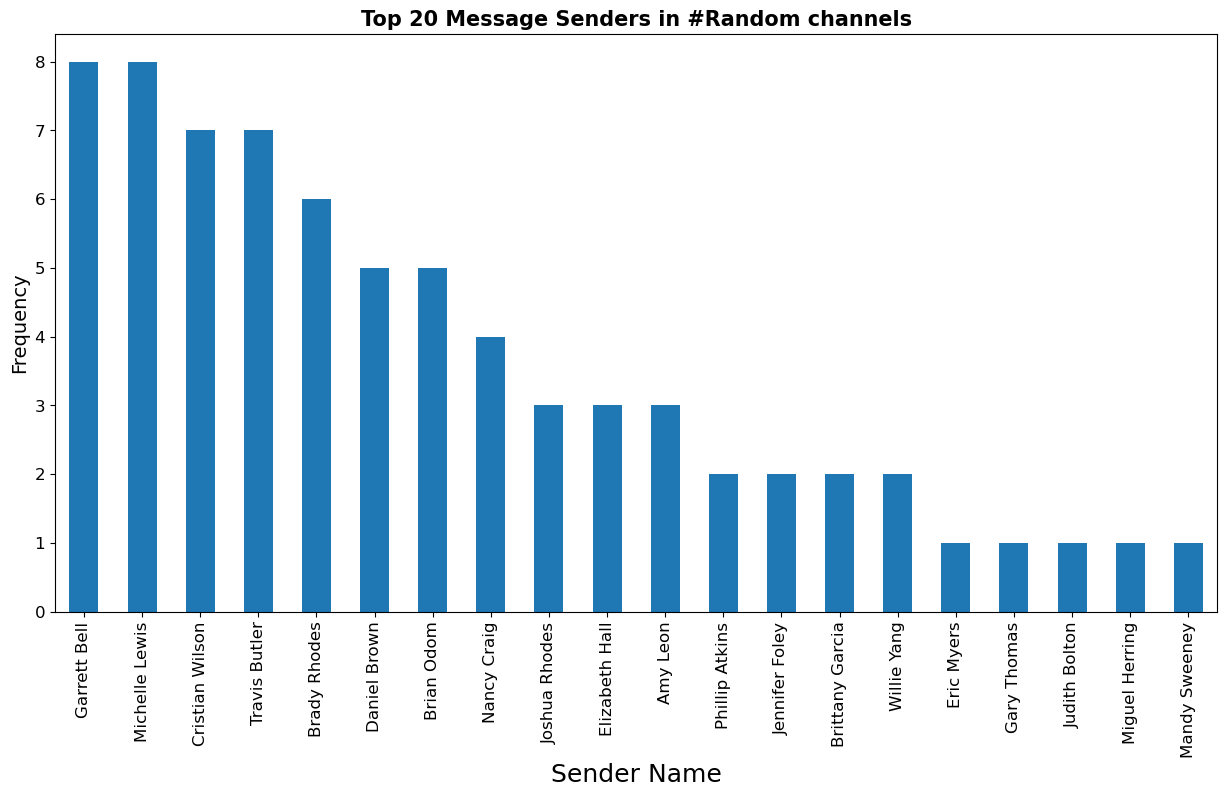

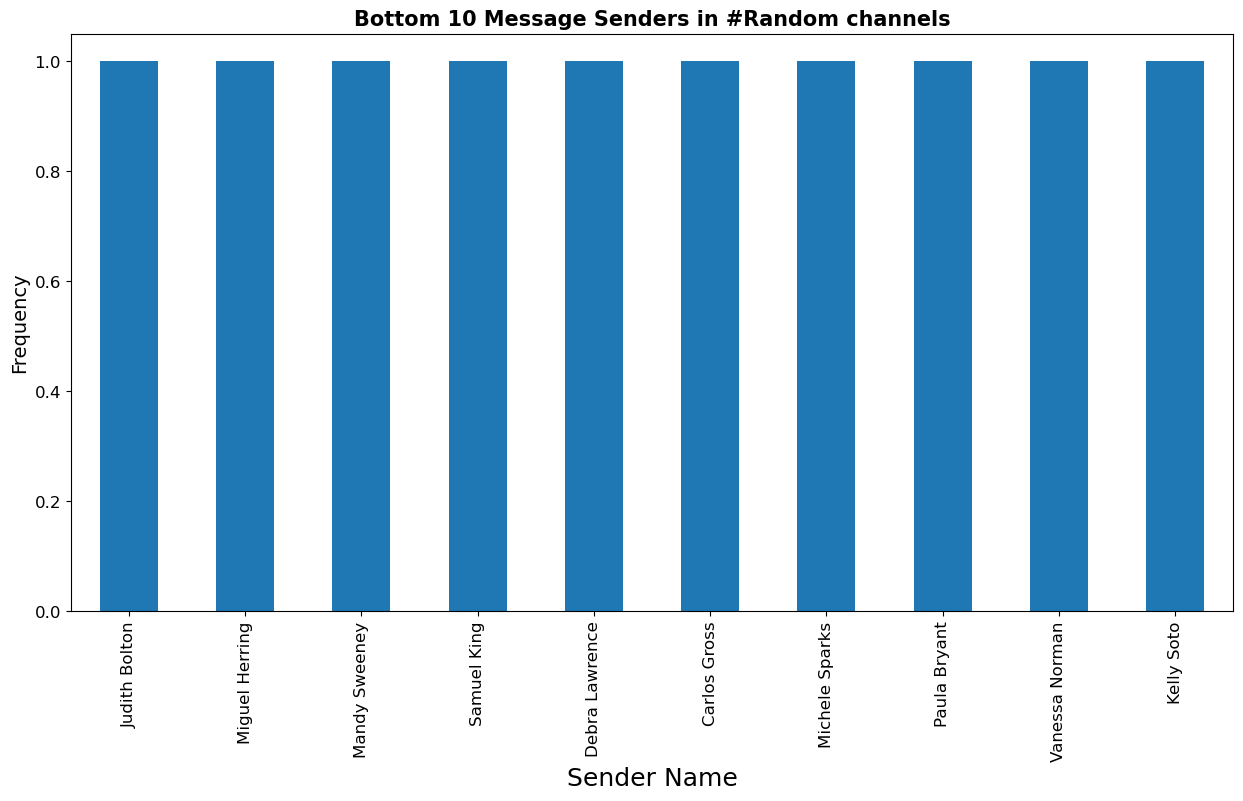

In [32]:

data = data_loader.slack_parser(channel_path)
get_top_20_user(data)

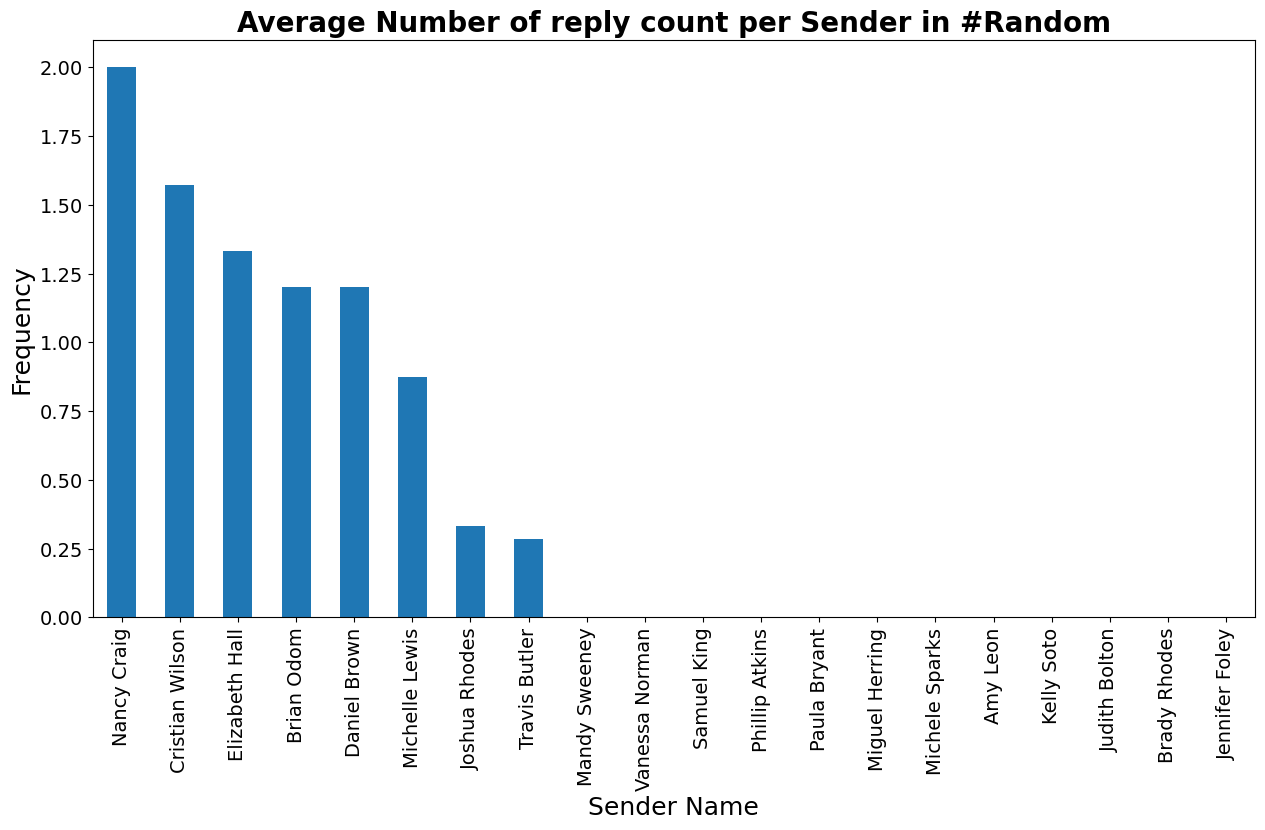

In [33]:
draw_avg_reply_count(data)

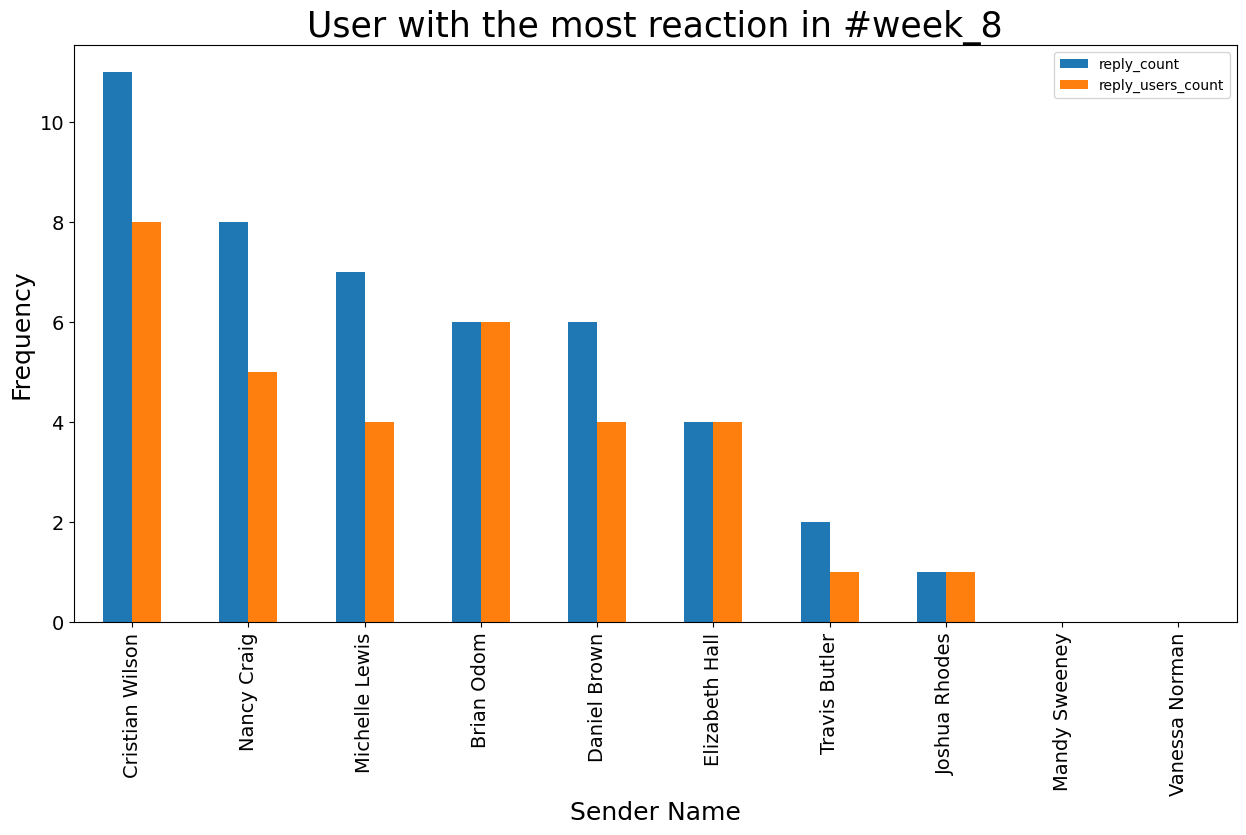

In [36]:
draw_user_reaction(data, 'week_8')

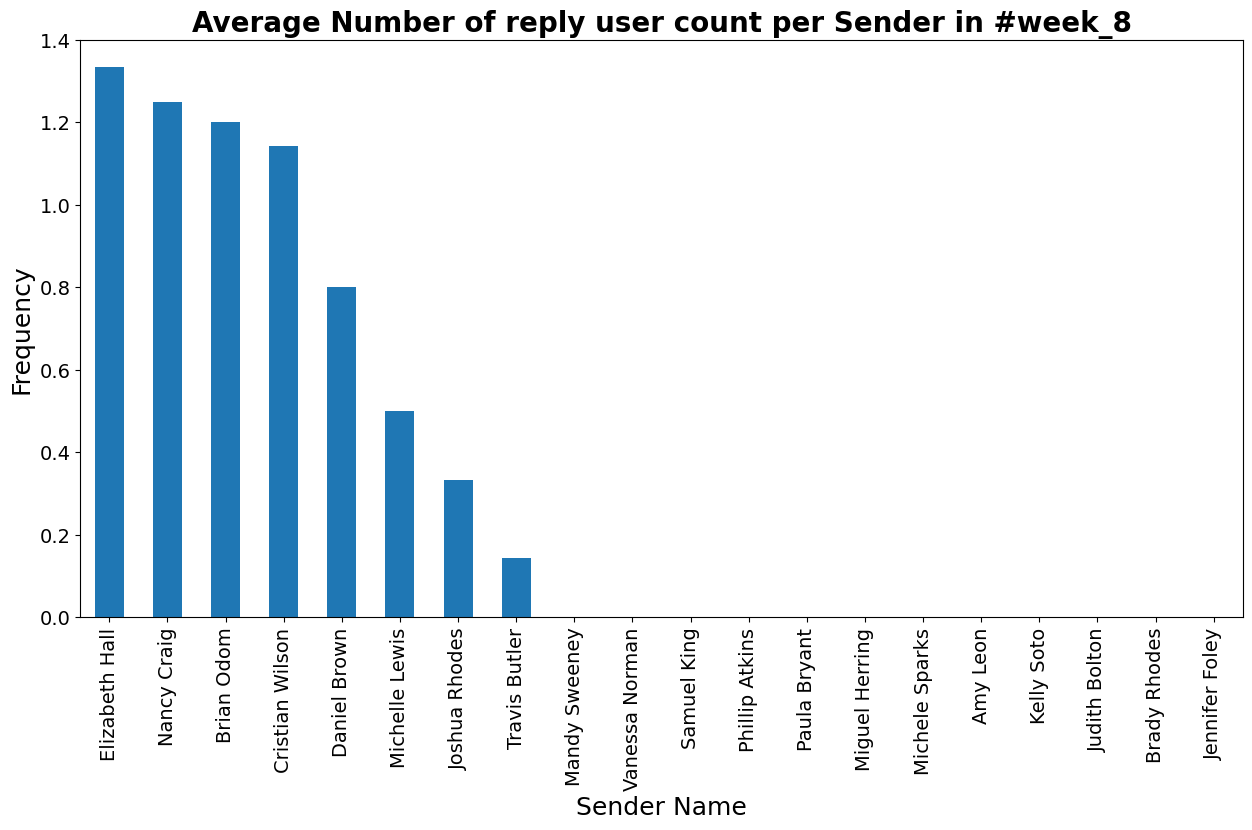

In [34]:
draw_avg_reply_users_count(data,'week_8')